# Quantum k-means clustering

Dynex is the world’s only accessible neuromorphic quantum computing cloud for solving real-world problems, at scale.. This example demonstrates how to use the Dynex SDK to use Pyton to compute on the Dynex Platform with Python.

In [19]:
import dynex
import dimod
from sklearn.datasets import make_blobs
from collections import defaultdict
import matplotlib.pyplot as plt
import math
import dwavebinarycsp #pip install dwavebinarycsp

A demo on identifying clusters in a data set using the Dynex platform.

When dealing with large data sets, we do not always have neatly labeled data (i.e. most, if not all, the data could be unlabeled). However, all is not lost as we can still extract insights from this data through clustering.

For example, when dealing with housing data---namely, square footage and price---we can identify clusters in that data which may be indicative of different neighborhoods. Another example could be having a boolean vector of TV shows that consumers watch; clusters in this data could help identify a particular consumer demographic.

As well, if we do have a few labelled data points in our data set, we could potentially label the entire cluster based on these.

## Support functions

In [24]:
def get_groupings(sample):
    """Grab selected items and group them by color"""
    colored_points = defaultdict(list)

    for label, bool_val in sample.items():
        # Skip over items that were not selected
        if not bool_val:
            continue

        # Parse selected items
        # Note: label look like "<x_coord>,<y_coord>_<color>"
        coord, color = label.split("_")
        coord_tuple = tuple(map(float, coord.split(",")))
        colored_points[color].append(coord_tuple)

    return dict(colored_points)


def visualize_groupings(groupings_dict):
    """
    Args:
        groupings_dict: key is a color, value is a list of x-y coordinate tuples.
          For example, {'r': [(0,1), (2,3)], 'b': [(8,3)]}
        filename: name of the file to save plot in
    """
    for color, points in groupings_dict.items():
        # Ignore items that do not contain any coordinates
        if not points:
            continue

        # Populate plot
        point_style = color + "o"
        plt.plot(*zip(*points), point_style)

    plt.show()


def visualize_scatterplot(x_y_tuples_list, filename):
    """Plotting out a list of x-y tuples

    Args:
        x_y_tuples_list: A list of x-y coordinate values. e.g. [(1,4), (3, 2)]
    """
    plt.plot(*zip(*x_y_tuples_list), "o")
    plt.savefig(filename)

class Coordinate:
    def __init__(self, x, y):
        self.x = x
        self.y = y

        # coordinate labels for groups red, green, and blue
        label = "{0},{1}_".format(x, y)
        self.r = label + "r"
        self.g = label + "g"
        self.b = label + "b"


def get_distance(coordinate_0, coordinate_1):
    diff_x = coordinate_0.x - coordinate_1.x
    diff_y = coordinate_0.y - coordinate_1.y

    return math.sqrt(diff_x**2 + diff_y**2)


def get_max_distance(coordinates):
    max_distance = 0
    for i, coord0 in enumerate(coordinates[:-1]):
        for coord1 in coordinates[i+1:]:
            distance = get_distance(coord0, coord1)
            max_distance = max(max_distance, distance)

    return max_distance

## Quantum k-means clustering function

In [25]:
def cluster_points(scattered_points):
    """Perform clustering analysis on given points

    Args:
        scattered_points (list of tuples):
            Points to be clustered
        filename (str):
            Output file for graphic
        problem_inspector (bool):
            Whether to show problem inspector
    """
    # Set up problem
    # Note: max_distance gets used in division later on. Hence, the max(.., 1)
    #   is used to prevent a division by zero
    coordinates = [Coordinate(x, y) for x, y in scattered_points]
    max_distance = max(get_max_distance(coordinates), 1)

    # Build constraints
    csp = dwavebinarycsp.ConstraintSatisfactionProblem(dwavebinarycsp.BINARY)

    # Apply constraint: coordinate can only be in one colour group
    choose_one_group = {(0, 0, 1), (0, 1, 0), (1, 0, 0)}
    for coord in coordinates:
        csp.add_constraint(choose_one_group, (coord.r, coord.g, coord.b))

    # Build initial BQM
    bqm = dwavebinarycsp.stitch(csp)

    # Edit BQM to bias for close together points to share the same color
    for i, coord0 in enumerate(coordinates[:-1]):
        for coord1 in coordinates[i+1:]:
            # Set up weight
            d = get_distance(coord0, coord1) / max_distance  # rescale distance
            weight = -math.cos(d*math.pi)

            # Apply weights to BQM
            bqm.add_interaction(coord0.r, coord1.r, weight)
            bqm.add_interaction(coord0.g, coord1.g, weight)
            bqm.add_interaction(coord0.b, coord1.b, weight)

    # Edit BQM to bias for far away points to have different colors
    for i, coord0 in enumerate(coordinates[:-1]):
        for coord1 in coordinates[i+1:]:
            # Set up weight
            # Note: rescaled and applied square root so that far off distances
            #   are all weighted approximately the same
            d = math.sqrt(get_distance(coord0, coord1) / max_distance)
            weight = -math.tanh(d) * 0.1

            # Apply weights to BQM
            bqm.add_interaction(coord0.r, coord1.b, weight)
            bqm.add_interaction(coord0.r, coord1.g, weight)
            bqm.add_interaction(coord0.b, coord1.r, weight)
            bqm.add_interaction(coord0.b, coord1.g, weight)
            bqm.add_interaction(coord0.g, coord1.r, weight)
            bqm.add_interaction(coord0.g, coord1.b, weight)

    # Submit problem to Dynex sampler
    sampleset = dynex.sample(bqm, mainnet=False, num_reads=1024, annealing_time=200);
    
    best_sample = sampleset.first.sample

    # Visualize solution
    groupings = get_groupings(best_sample)
    visualize_groupings(groupings)

    # Print solution onto terminal
    # Note: This is simply a more compact version of 'best_sample'
    print(groupings)


## Compute

In [26]:
scattered_points = [(0, 0), (1, 1), (2, 4), (3, 2)]

[DYNEX] PRECISION SET TO 0.0001
[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬───────────────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │ ELAPSED   │ WORKERS READ              │ CIRCUITS   │ STEPS   │ GROUND STATE   │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼───────────────────────────┼────────────┼─────────┼────────────────┤
│         -1 │       20 │             158 │           0 │           │ *** WAITING FOR READS *** │            │         │                │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴───────────────────────────┴────────────┴─────────┴────────────────╯

[DYNEX] FINISHED READ AFTER 0.25 SECONDS
[DYNEX] SAMPLESET READY


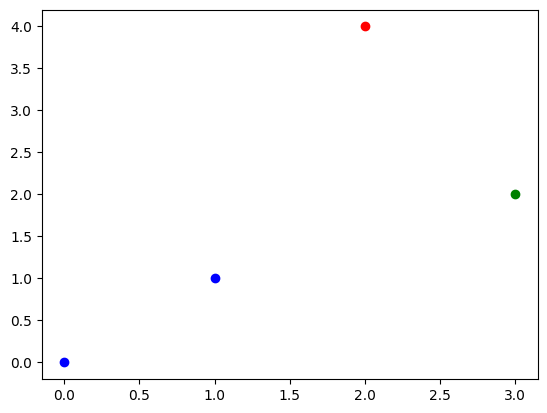

{'b': [(0.0, 0.0), (1.0, 1.0)], 'r': [(2.0, 4.0)], 'g': [(3.0, 2.0)]}


In [27]:
cluster_points(scattered_points)